In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import os
from dataclasses import dataclass
import utils
from torch_geometric_temporal import StaticGraphTemporalSignal
import networkx as nx
import torch_geometric

In [64]:
graph = nx.complete_graph(18)
self_loops = [[node,node]for node in graph.nodes()]
graph.add_edges_from(self_loops)
edges = np.array(torch_geometric.utils.from_networkx(graph))[0][1].numpy()

C:\Users\Szymon Mazurek\AppData\Local\Temp\ipykernel_17040\2176235635.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  edges = np.array(torch_geometric.utils.from_networkx(graph))[0][1].numpy()


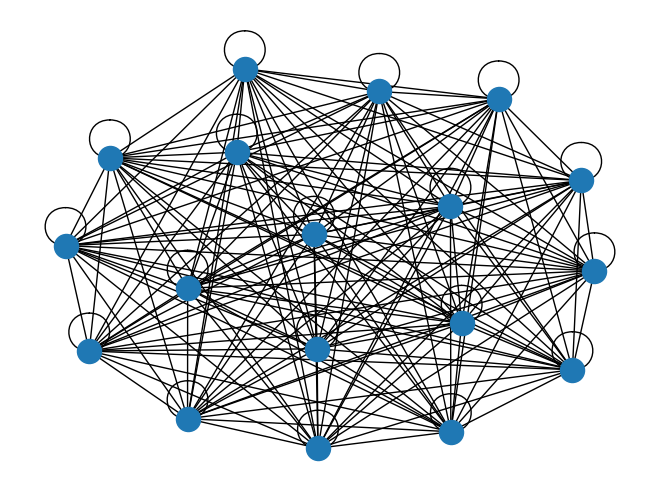

In [65]:
nx.draw(graph)

In [59]:

@dataclass
class SeizureDataLoader:
    npy_dataset_path :str
    event_tables_path : str
    loso_patient : str = None
    sampling_f : int = 256
    seizure_lookback: int = 600
    sample_timestep: int = 5
    overlap: int = 0
    self_loops : bool = True

    def _get_event_tables(self,patient_name):
        event_table_list = os.listdir(self.event_tables_path)
        patient_start_table, patient_stop_table = [os.path.join(self.event_tables_path,ev_table)
        for ev_table in event_table_list if patient_name in ev_table]
        start_events_dict = self._load_csv_table_events(patient_start_table)
        stop_events_dict = self._load_csv_table_events(patient_stop_table)
        return start_events_dict,stop_events_dict
        
    def _get_recording_events(self,events_dict,recording):
        recording_list = list(events_dict[recording+'.edf'].values())
        recording_events = [int(x) for x in recording_list if not np.isnan(x)]
        return recording_events

    def _load_csv_table_events(self,table_path):
        event_dict = pd.read_csv(table_path).to_dict('index')
        return event_dict
    
    def _get_edges(self):
        ## TODO implement creation of nodes based on PLV? Ask Rosmary about that
        n_nodes = self._features.shape[1]
        graph = nx.complete_graph(n_nodes)
        self_loops = [[node,node]for node in graph.nodes()]
        graph.add_edges_from(self_loops)
        self._edges = np.array(torch_geometric.utils.from_networkx(graph))[0][1].numpy()
    
    def _get_edge_weights(self):
        self._edge_weights = np.ones(self._edges.shape[1])

    def _get_labels_and_features(self):
        ## Prepare samples  for the dataset
        patient_list = os.listdir(self.npy_dataset_path)
        for patient in patient_list: # iterate over patient names
            event_tables = self._get_event_tables(patient) # extract start and stop of seizure for patient 
            patient_path = os.path.join(self.npy_dataset_path,patient)
            recording_list = os.listdir(patient_path)
            for record in recording_list: # iterate over recordings for a patient
                recording_path = os.path.join(patient_path,record)
                record_id = record.split('.npy')[0] #  get record id
                start_event_tables = self._get_recording_events(event_tables[0],record_id) # get start events
                stop_event_tables = self._get_recording_events(event_tables[1],record_id) # get stop events
                data_array = np.load(recording_path) # load the recording
                ##TODO add a gateway to reject seizure periods shorter than lookback
                # extract timeseries and labels from the array
                features,labels,time_labels = utils.extract_training_data_and_labels(
                    data_array,
                    start_event_tables,
                    stop_event_tables,
                    fs = self.sampling_f,
                    seizure_lookback = self.seizure_lookback,
                    sample_timestep = self.sample_timestep,
                    overlap = self.overlap,
                )
                if patient == self.loso_patient:
                    self._val_features = features
                    self._val_labels = labels
                    self._val_time_labels = time_labels
                else:
                    try:
                        self._features = np.concatenate((self._features, features))
                        self._labels = np.concatenate((self._labels, labels))
                        self._time_labels = np.concatenate((self._time_labels , time_labels))
                    except:
                        print("Creating initial attributes")
                        self._features = features
                        self._labels = labels
                        self._time_labels = time_labels
    # TODO define a method to create edges and calculate plv to get weights
    def get_dataset(self) -> StaticGraphTemporalSignal:
        """Creating the Dog age video keypoints data iterator. The iterator yelds static,
        fully connected, unweighted graphs with bodyparts assigned to given node and label for every
        set of features. A set of features describes given clip (collection of following frames).
        Features are of shape [nodes,features,timesteps].

        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Dog Age Video dataset.
        """
               
        
        self._get_labels_and_features()
        self._get_edges()
        self._get_edge_weights()
        train_dataset = StaticGraphTemporalSignal(
        self._edges, self._edge_weights, self._features, self._labels
        )

        val_dataset = StaticGraphTemporalSignal(
        self._edges, self._edge_weights, self._val_features, self._val_labels
        )
        
        return train_dataset, val_dataset
                

        

In [60]:
dataloader = SeizureDataLoader(Path('npy_data'),Path('event_tables'),loso_patient='chb16')

In [62]:
train_loader,val_loader=dataloader.get_dataset()

C:\Users\Szymon Mazurek\AppData\Local\Temp\ipykernel_17040\547328840.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._edges = np.array(torch_geometric.utils.from_networkx(graph))[0][1].numpy()


In [53]:
dataloader._get_edges()

C:\Users\Szymon Mazurek\AppData\Local\Temp\ipykernel_17040\1257347122.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._edges = np.array(torch_geometric.utils.from_networkx(graph))[0][1].numpy()


In [ ]:
df = dataloader._get_event_tables('chb16')

In [ ]:
list_to_process =dataloader._get_recording_events(df[0], 'chb16_10')

In [ ]:
list_to_process

In [ ]:
[x for x in list_to_process if not np.isnan(x)]

In [ ]:
df.to_dict('index')

In [ ]:
path_to_file = Path("raw_dataset\chb16\chb16-summary.txt")
open(path_to_file,'r').readlines()

In [ ]:
string = 'chb10_27.edf'

In [ ]:
string.split('.edf')[0]

In [ ]:
ds_path = Path('preprocessed_data')
target_path = Path('npy_data')

In [ ]:
save_timeseries_array(ds_path,target_path)

In [ ]:
def get_patient_annotations(path_to_file : Path, savedir : Path):
    raw_txt = open(path_to_file,'r')
    raw_txt_lines = raw_txt.readlines()
    event_dict_start = dict()
    event_dict_stop = dict()
    p = '[\d]+'
    for n,line in enumerate(raw_txt_lines):
        if "File Name" in line:
            current_file_name = line.split(': ')[1][:-1]
        if "Number of Seizures in File" in line:
            num_of_seizures = int(line[-2:])
            if  num_of_seizures > 0:
                events_in_recording = raw_txt_lines[n+1:n+num_of_seizures*2+1]
                for event in events_in_recording:
                    if "Start Time" in event:
                        sub_ev = event.split(': ')[1]
                        time_value = int(re.search(p,sub_ev).group())
                
                        if not current_file_name in event_dict_start.keys():
                            event_dict_start[current_file_name] = [time_value]
                        else:
                            event_dict_start[current_file_name].append(time_value)
                    elif "End Time" in event:
                        sub_ev = event.split(': ')[1]
                        
                        time_value = int(re.search(p,sub_ev).group())
                        
                        if not current_file_name in event_dict_stop.keys():
                            event_dict_stop[current_file_name] = [time_value]
                            
                        else:
                            event_dict_stop[current_file_name].append(time_value)
    df = pd.DataFrame.from_dict(event_dict_start,orient='index')
    col_list = []
    for n in range(1,len(df.columns)+1):
        col_list.append(f'Seizure {n}')
    df_start = pd.DataFrame.from_dict(event_dict_start,orient='index',columns=col_list)
    df_end = pd.DataFrame.from_dict(event_dict_stop,orient='index',columns=col_list)
    patient_id = current_file_name.split('_')[0]
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    dst_dir_start = os.path.join(savedir,f"{patient_id}_start.csv")
    dst_dir_stop = os.path.join(savedir,f"{patient_id}_stop.csv")
    pd.DataFrame.to_csv(df_start,dst_dir_start,index_label=False) 
    pd.DataFrame.to_csv(df_end,dst_dir_stop,index_label=False) 

In [ ]:
def get_annotation_files(dataset_path):
    patient_folders = os.listdir(dataset_path)
    for folder in patient_folders:
        patient_folder_path = os.path.join(dataset_path,folder)
        if os.path.isdir(patient_folder_path):
            patient_files = os.listdir(patient_folder_path)
            for filename in patient_files:
                if "summary" in filename:
                    annotation_path = os.path.join(patient_folder_path,filename)
                    get_patient_annotations(annotation_path,Path("event_tables"))


In [ ]:
annotation_files = get_annotation_files(Path("raw_dataset"))
